In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain


### Helpers

In [2]:
mu0 = 4 * np.pi * 10**-7

def estore_from_approx_beta_poloidal(Ip, beta, R0):
    return np.power(Ip,2)*beta*R0*3.0/8.0*mu0

from omfit_classes.omfit_eqdsk import boundaryShape

### Build machine

In [3]:
r,z,zeff= boundaryShape(kapu = 1.65, kapl = 1.65, delu = -0.4, dell = -0.4, zetail = -.2, zetaiu = -.2, zetaou = 0, zetaol = 0, a = 0.35, eps = 0.35/0.8, zoffset = 0, upnull = False, lonull = False, npts = 8)
vv_pts = np.column_stack((r,z))
coils = {
    'CS0': {'rc': 0.25, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.25, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.25, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': 1.7, 'zc': 0.4, 'w': 0.2, 'h': 0.2},
    'EF1U': {'rc': 1.22, 'zc': 0.65, 'w': 0.2, 'h': 0.2},
    'EF2U': {'rc': 0.98, 'zc': 0.7, 'w': 0.2, 'h': 0.2},
    'EF3U': {'rc': 0.56, 'zc': 0.55, 'w': .2, 'h': .2},

    'EF0L': {'rc': 1.7, 'zc': -0.4, 'w': 0.2, 'h': 0.2},
    'EF1L': {'rc': 1.22, 'zc': -0.65, 'w': 0.2, 'h': 0.2},
    'EF2L': {'rc': 0.98, 'zc': -0.7, 'w': 0.2, 'h': 0.2},
    'EF3L': {'rc': 0.56, 'zc': -0.55, 'w': .2, 'h': .2},
  
}

In [4]:
## Define mesh resolution in each region
plasma_resolution = 0.03
coil_resolution = 0.03
vv_resolution = 0.03
vac_resolution = 0.075

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')      # Define the bounding region
gs_mesh.define_region('plasma',plasma_resolution,'plasma')  # Define the plasma region and resolution
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [6]:
# Define vaccum vessel geometry
gs_mesh.add_polygon(vv_pts,'plasma',parent_name='air')             # Define the shape of the limiter
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

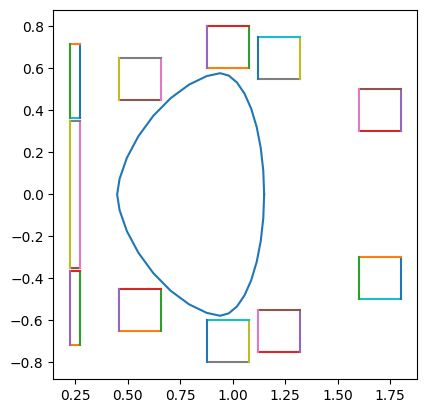

In [7]:
## Plot geometry
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [8]:
#Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 490
  # of unique segments  = 49
Generating mesh:
  # of points  = 2711
  # of cells   = 5314
  # of regions = 13


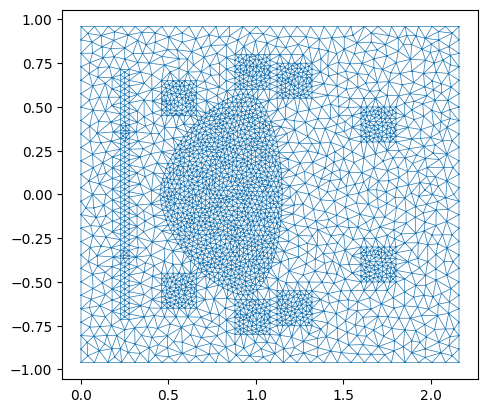

In [9]:
# Plot mesh
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1], lw = 0.5)

### Set Targets

In [10]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.8*3) ## F0 = R0 * B0

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.147E+00
    # of points  =    2711
    # of edges   =    8024
    # of cells   =    5314
    # of boundary points =     106
    # of boundary edges  =     106
    # of boundary cells  =     106
  Resolution statistics:
    hmin =  1.500E-02
    hrms =  4.500E-02
    hmax =  1.057

In [11]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[2,2] = 1
targets[0] = -5E5
targets[1] = -5E5 
targets[2] = -5E5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)


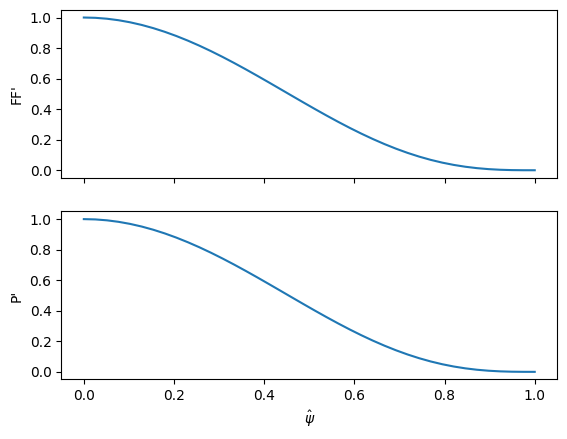

In [12]:
# Define shape of P' anf FF' profiles

n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [13]:
#Define global quantities
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1) #Can change poloidal beta by modifying Ip_ratio target

In [14]:
##Set shape targets
kappa = 1.7
delta = -0.7

r, z, zeff = boundaryShape(kapu = kappa, kapl = kappa, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.8, zoffset = 0, upnull = False, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
isoflux_weights = 10*np.ones(32)
mygs.set_isoflux(boundary, isoflux_weights)

#Set saddle targets
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)



### Compute equilibrium

In [15]:
mygs.init_psi(0.8,0,0.22, kappa,delta) #Initial "guess"
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  1.0011E+01  7.1666E+00  2.3981E-02  8.4316E-01  1.3349E-02 -0.0000E+00
     2  1.0409E+01  7.5361E+00  7.7143E-03  8.4336E-01  1.4408E-02 -0.0000E+00
     3  1.0453E+01  7.6099E+00  2.2430E-03  8.4304E-01  1.5200E-02 -0.0000E+00
     4  1.0467E+01  7.6433E+00  8.0515E-04  8.4266E-01  1.5827E-02 -0.0000E+00
     5  1.0474E+01  7.6617E+00  3.9113E-04  8.4237E-01  1.6337E-02 -0.0000E+00
     6  1.0479E+01  7.6728E+00  2.3693E-04  8.4216E-01  1.6758E-02 -0.0000E+00
     7  1.0483E+01  7.6800E+00  1.6252E-04  8.4203E-01  1.7107E-02 -0.0000E+00
     8  1.0487E+01  7.6849E+00  1.2066E-04  8.4196E-01  1.7399E-02 -0.0000E+00
     9  1.0490E+01  7.6884E+00  9.4552E-05  8.4192E-01  1.7644E-02 -0.0000E+00
    10  1.0492E+01  7.6910E+00  7.6642E-05  8.4189E-01  1.7849E-02 -0.0000E+00
    11  1.0495E+01  7.6931E+00  6.3309E-05  8.4188E-01  1.8021E-02 -0.0000E+00
    12  1.0497E+01  7.6947E+00  5.2795E-05  8.4188E-01  1.8165E-02 -0.0000E+00
    13  1.0499E+01  7.

0

[ 0.9765028  -0.43445791]
[0.98255702 0.4394896 ]
bye
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.0000E+06
  Current Centroid [m]    =    0.830  0.019
  Magnetic Axis [m]       =    0.842  0.019
  Elongation              =    1.635 (U:  1.688, L:  1.582)
  Triangularity           =   -0.476 (U: -0.710, L: -0.242)
  Plasma Volume [m^3]     =    1.627
  q_0, q_95               =    0.593  2.191
  Peak Pressure [Pa]      =    4.2026E+05
  Stored Energy [J]       =    1.8280E+05
  <Beta_pol> [%]          =   51.3167
  <Beta_tor> [%]          =    2.2525
  Diamagnetic flux [Wb]   =    9.8668E-03
  Toroidal flux [Wb]      =    9.5840E-01
  l_i                     =    1.2363


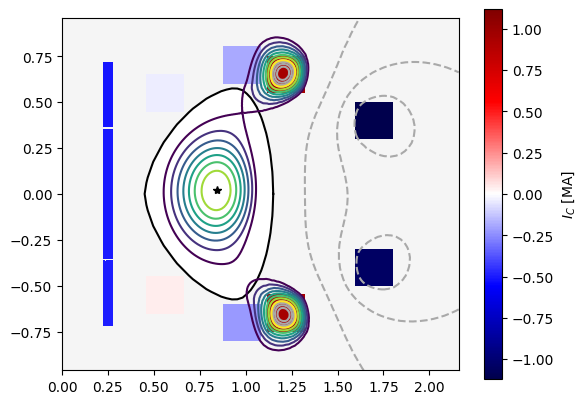

In [16]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.print_info()

In [17]:
## Print equilibrium info
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

[ 0.9765028  -0.43445791]
[0.98255702 0.4394896 ]
bye
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.0000E+06
  Current Centroid [m]    =    0.830  0.019
  Magnetic Axis [m]       =    0.842  0.019
  Elongation              =    1.635 (U:  1.688, L:  1.582)
  Triangularity           =   -0.476 (U: -0.710, L: -0.242)
  Plasma Volume [m^3]     =    1.627
  q_0, q_95               =    0.593  2.191
  Peak Pressure [Pa]      =    4.2026E+05
  Stored Energy [J]       =    1.8280E+05
  <Beta_pol> [%]          =   51.3167
  <Beta_tor> [%]          =    2.2525
  Diamagnetic flux [Wb]   =    9.8668E-03
  Toroidal flux [Wb]      =    9.5840E-01
  l_i                     =    1.2363

Coil Currents [MA]:
  CS0:            -0.50
  CS1:            -0.50
  CS2:            -0.51
  EF0U:           -1.12
  EF1U:            0.95
  EF2U:           -0.19
  EF3U:           -0.04
  EF0L:           -1.05
  EF1L:            0.95
  EF2L:           -0.22
  EF3L:  

In [18]:
_,qvals,_,dl,rbounds,zbounds = mygs.get_q(np.r_[1.0-.01,0.95,0.02]) 

In [19]:
print(rbounds)
print(zbounds)
print(((rbounds[1,0]+rbounds[0,0])/2.0-zbounds[1,0])*2.0/(rbounds[1,0]-rbounds[0,0]))
print(((rbounds[1,0]+rbounds[0,0])/2.0-zbounds[0,0])*2.0/(rbounds[1,0]-rbounds[0,0]))
print(((rbounds[1,0]+rbounds[0,0])/2.0-(zbounds[1,0]+zbounds[0,0])/2.0)*2.0/(rbounds[1,0]-rbounds[0,0]))

[[0.55667319 0.00941827]
 [1.05492679 0.02644415]]
[[ 0.8661622  -0.37519772]
 [ 0.92885341  0.42133878]]
-0.4939389097156769
-0.24229512226568803
-0.36811701599068225


In [20]:
stats = mygs.get_stats()
print(stats['delta'])

[ 0.9765028  -0.43445791]
[0.98255702 0.4394896 ]
bye
-0.4759007016999398


In [21]:
print(mygs.x_points)

[[ 0.9765028  -0.43445791]
 [ 0.98255702  0.4394896 ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]
 [-1.          0.        ]]


In [22]:
if mygs.diverted:
    for i in range(mygs.x_points.shape[0]):
        print('restart')
        if mygs.x_points[i,0] < 0.0:
            break
        x_active = mygs.x_points[i,:]
        print(x_active)
        if x_active[1] < zbounds[0,1]:
            zbounds[0,:] = x_active
            print('hi')
        elif x_active[1] > zbounds[1,1]:
            zbounds[1,:] = x_active
            print('bye')

restart
[ 0.9765028  -0.43445791]
hi
restart
[0.98255702 0.4394896 ]
bye
restart


In [23]:
print(rbounds)
print(zbounds)
print(((rbounds[1,0]+rbounds[0,0])/2.0-zbounds[1,0])*2.0/(rbounds[1,0]-rbounds[0,0]))
print(((rbounds[1,0]+rbounds[0,0])/2.0-zbounds[0,0])*2.0/(rbounds[1,0]-rbounds[0,0]))
print(((rbounds[1,0]+rbounds[0,0])/2.0-(zbounds[1,0]+zbounds[0,0])/2.0)*2.0/(rbounds[1,0]-rbounds[0,0]))

[[0.55667319 0.00941827]
 [1.05492679 0.02644415]]
[[ 0.9765028  -0.43445791]
 [ 0.98255702  0.4394896 ]]
-0.7095062811341917
-0.6852045440249646
-0.6973554125795781


## Save to eqdsk file

In [24]:
mygs.save_eqdsk('temp', lcfs_pad = .00001, nr = 600, nz = 600)

Saving EQDSK file
 "none"


In [25]:
from omfit_classes.omfit_eqdsk import OMFITgeqdsk


eqdsk = OMFITgeqdsk('temp')
elong = eqdsk['fluxSurfaces']['geo']['kap'][-1]
triang = eqdsk['fluxSurfaces']['geo']['delta'][-1]

Flux surfaces from 600x600 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.0024700536672286875 [m]
Cropping tables ...
Find magnetic axis ...
Find separatrix ...
Tracing flux surfaces ...
  > Took 0:00:01.742693
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:01.087007
Flux surface averaging ...
  > Took 0:00:01.362561
Geometric quantities ...
  > Took 0:00:02.970893


In [26]:
print('Elongation: {}'.format(elong))
print('Triangularity: {}'.format(triang))

Elongation: 1.6324474506788482
Triangularity: -0.4812590403885197
